# Objective
***
The objective is to classify cells as **Parasitized** or **Uninfected** using a **Convolutional Neural Network**.

First, we do the standard imports:

In [21]:
import numpy as np
np.random.seed(1000)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
import keras
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

import os
import cv2
from PIL import Image

# Loading the Data
***
Now we will load the data in.

We set the image size to be 64x64

In [3]:
DATA_DIR = "data/"
SIZE = 64
dataset = []
label = []

Load the infected images

In [14]:
parasitized_images = os.listdir( DATA_DIR + "Parasitized/" )
for i, image_name in enumerate( parasitized_images ):
    try:
        # if the extension is png
        if (image_name.split('.')[1] == "png"):
            # read a csv into a 208x148x3 numpy array
            image = cv2.imread( DATA_DIR + "Parasitized/" + image_name )
            # read numpy array into a 148x208 object of type instance
            image = Image.fromarray( image, "RGB" )
            image = image.resize( (SIZE, SIZE) )
            dataset.append(np.array(image))
            label.append(0)
    except Exception:
        print("Could not read image {} with name {}".\
             format(i, image_name))

Load the clean images

In [16]:
uninfected_images = os.listdir(DATA_DIR + 'Uninfected/')
for i, image_name in enumerate(uninfected_images):
    try:
        if (image_name.split('.')[1] == 'png'):
            image = cv2.imread(DATA_DIR + 'Uninfected/' + image_name)
            image = Image.fromarray(image, 'RGB')
            image = image.resize((SIZE, SIZE))
            dataset.append(np.array(image))
            label.append(1)
    except Exception:
        print("Could not read image {} with name {}".format(i, image_name))

# Visualizing the Data
***
Here are 5 random infected cells:

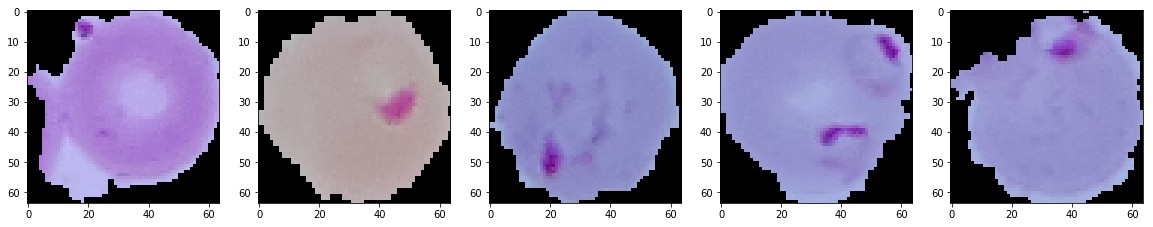

In [15]:
plt.figure(figsize=(20,12))
for index, image_index in enumerate(np.random.randint(len(parasitized_images),size=5)):
    plt.subplot(1,5, index+1)
    plt.imshow(dataset[image_index])

Here are 5 random clean cells:

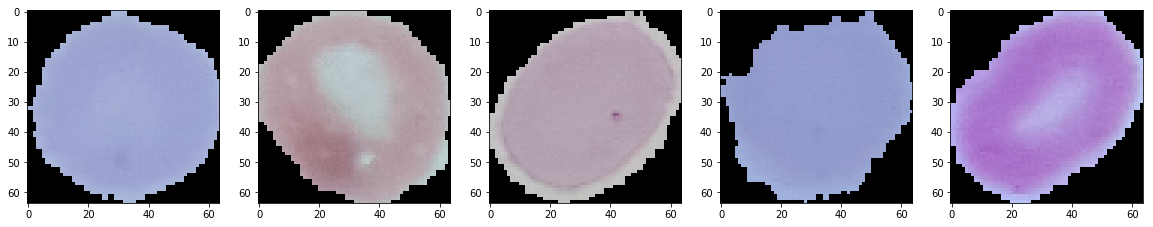

In [17]:
plt.figure(figsize=(20,12))
for index, image_index in enumerate(np.random.randint(len(uninfected_images),size=5)):
    plt.subplot(1,5, index+1)
    plt.imshow(dataset[len(parasitized_images)+image_index])

# Building the CNN
***
We will build a convolutional neural network using `Keras`.

Here is a description of the different layers:
## Convolution2D
This creates a convolution kernel. The convolution kernel requires the following properties to be set:
* **filter** - defines the output shape of the convolutional layer. In this case, we use 32 as the value
* **kernel_size** - this defines the size of the window we use to traverse the input image. in this case, we'll use a 3x3 matrix
* **input_shape** - this is the input size of each image. because our iamges are of size 64x64 and consist of three colors, we pass to the parameter the tuple (64,64,3). We only use this parameter for the first layer
* **activation** - the activation function is the nonlinear function we apply to the output of the convolution. we'll use `relu` for our CNN
## MaxPool2D
This function performs a max pooling aggregation in order to downscale the dimensionality of the outputs.

The following parameters need to be set:
* **pool_size** - this defines the matrix size, which defines the number of pixel values that will be aggregated into a single value. We perform the aggregation over 2x2 squares of input, resulting in a net halving of the size of the image. in this case, the 62x62 image is converted to a 31x31 output
* **data_format** - this describes the input size of the data. here, we set it to be `channels_last` so that it will take the output of the previous layer to be the size of the input
## BatchNormalization
This normalizes the output from the previous activation function. It has one parameter to modify:
* **axis** - the axis to be normalized. because we used `channels_last`, we have to set this value to be -1
## Dropout
This layer sets a random proportion of nodes to drop out during training. It does this by setting the output of the chosen nodes to be 0. This is a commonly used method to prevent overfitting.
* **rate** - fraction of nodes to be dropped
## Flatten
This layer flattens the matrix into a single array. So if the original size of the matrix was 64x64x3, then it will be converted into a (64)(64)(3)=12288 dimensional array. This is what will be used as the input for the next dense layer
## Dense
This layer defiens a fully connected neural network layer, and it takes the following two parameters:
* **activation** - set the activation to be `relu`. We only set the first dense layer to have the `relu` nonlinearity. We will use the `sigmoid` activation for the last dense layer
* **units** - this defines the number of nodes in this layer. 

In [20]:
model = Sequential()

model.add( Convolution2D(32, (3, 3), \
        input_shape=(SIZE, SIZE, 3), activation='relu') )
model.add( MaxPooling2D( pool_size=(2,2), \
                        data_format="channels_last" ) )
model.add( BatchNormalization( axis=-1 ) )
model.add( Dropout(0.2) )

model.add( Convolution2D(32, (3, 3), \
        input_shape=(SIZE, SIZE, 3), activation='relu') )
model.add( MaxPooling2D( pool_size=(2,2), \
                        data_format="channels_last" ) )
model.add( BatchNormalization( axis=-1 ) )
model.add( Dropout(0.2) )

model.add( Flatten() )
model.add( Dense(activation='relu', units=512) )
model.add( BatchNormalization( axis=-1 ) )
model.add( Dropout(0.2) )
model.add( Dense(activation='relu', units=256) )
model.add( BatchNormalization( axis=-1 ) )
model.add( Dropout(0.2) )
model.add( Dense(activation='sigmoid', units=2) )

model.compile(optimizer='adam', loss='categorical_crossentropy',\
             metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 31, 31, 32)        128       
_________________________________________________________________
dropout_5 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 14, 14, 32)        128       
__________

# Splitting the Dataset
Now we will split the data set into a training and testing dataset. We will use 80% on the training set, and the remaining 20% on the testing data set.

In [22]:
X_train, X_test, y_train, y_test = train_test_split( dataset, \
    to_categorical(np.array(label)), test_size=0.2, random_state=0 )

# Train the Model

In [23]:
history = model.fit( np.array(X_train) , y_train, \
    batch_size=64, verbose=2, epochs=50, validation_split=0.1,\
    shuffle=False )

Instructions for updating:
Use tf.cast instead.
Train on 19841 samples, validate on 2205 samples
Epoch 1/50
 - 38s - loss: 0.4932 - acc: 0.7599 - val_loss: 4.7791 - val_acc: 0.5737
Epoch 2/50
 - 35s - loss: 0.2333 - acc: 0.9119 - val_loss: 0.8177 - val_acc: 0.7401
Epoch 3/50
 - 34s - loss: 0.1941 - acc: 0.9261 - val_loss: 0.2181 - val_acc: 0.9188
Epoch 4/50
 - 33s - loss: 0.1714 - acc: 0.9336 - val_loss: 0.1966 - val_acc: 0.9283
Epoch 5/50
 - 33s - loss: 0.1576 - acc: 0.9395 - val_loss: 0.1958 - val_acc: 0.9356
Epoch 6/50
 - 33s - loss: 0.1414 - acc: 0.9450 - val_loss: 0.1799 - val_acc: 0.9374
Epoch 7/50
 - 35s - loss: 0.1249 - acc: 0.9495 - val_loss: 0.1906 - val_acc: 0.9333
Epoch 8/50
 - 33s - loss: 0.1082 - acc: 0.9564 - val_loss: 0.1859 - val_acc: 0.9370
Epoch 9/50
 - 33s - loss: 0.0944 - acc: 0.9615 - val_loss: 0.1767 - val_acc: 0.9374
Epoch 10/50
 - 33s - loss: 0.0788 - acc: 0.9675 - val_loss: 0.2000 - val_acc: 0.9383
Epoch 11/50
 - 34s - loss: 0.0638 - acc: 0.9740 - val_loss: 0.

# Inspect the Accuracy 

In [24]:
print("Test_Accuracy: {:.2f}%".format( model.\
    evaluate(np.array(X_test), np.array(y_test))[1] * 100 ))

5512/5512 [==============================] - 3s 511us/step
Test_Accuracy: 94.12%


# Generate more Images to Improve Training

In [25]:
train_generator = ImageDataGenerator(rescale = 1/255,\
    zoom_range = 0.3,\
    horizontal_flip = True,\
    rotation_range = 30)

test_generator = ImageDataGenerator(rescale = 1/255)

train_generator = train_generator.flow(np.array(X_train),\
    y_train,\
    batch_size = 64,\
    shuffle = False)

test_generator = test_generator.flow(np.array(X_test),\
    y_test,\
    batch_size = 64,\
    shuffle = False)

Lets try training again

In [27]:
history = model.fit_generator(train_generator,
    steps_per_epoch = len(X_train)/64,\
    epochs = 50,\
    shuffle = False)

Epoch 1/50
344/344 [==============================] - 47s 137ms/step - loss: 0.2219 - acc: 0.9296
Epoch 2/50
344/344 [==============================] - 53s 155ms/step - loss: 0.1785 - acc: 0.9392
Epoch 3/50
344/344 [==============================] - 50s 146ms/step - loss: 0.1709 - acc: 0.9423
Epoch 4/50
344/344 [==============================] - 50s 144ms/step - loss: 0.1667 - acc: 0.9430
Epoch 5/50
344/344 [==============================] - 50s 145ms/step - loss: 0.1654 - acc: 0.9435
Epoch 6/50
344/344 [==============================] - 52s 152ms/step - loss: 0.1612 - acc: 0.9447
Epoch 7/50
344/344 [==============================] - 50s 145ms/step - loss: 0.1586 - acc: 0.9448
Epoch 8/50
344/344 [==============================] - 49s 144ms/step - loss: 0.1510 - acc: 0.9474
Epoch 9/50
344/344 [==============================] - 50s 144ms/step - loss: 0.1538 - acc: 0.9481
Epoch 10/50
344/344 [==============================] - 50s 144ms/step - loss: 0.1486 - acc: 0.9490
Epoch 11/50
344/344

In [28]:
print("Test_Accuracy(after augmentation): {:.2f}%".\
    format(model.evaluate_generator(test_generator, \
    steps = len(X_test), verbose = 1)[1]*100))

5512/5512 [==============================] - 137s 25ms/step
Test_Accuracy(after augmentation): 95.39%


Now we will save our model:

In [ ]:
SAVE_MODEL = False
if SAVE_MODEL:
    model.save("malaria_model.h5")

We can load our model with:
```python
from keras.models import load_model
model = load_model("malaria_model.h5")
```